## Aaron Martin

# **Synthetic Dataset for Battery Recycling Cluster Analysis**  

### **Project Overview**  
This project uses a synthetic dataset (AI-generated, *n* = 2,500) to explore clustering patterns in four key battery metals:  
- **Lithium (Li)**  
- **Cobalt (Co)**  
- **Nickel (Ni)**  
- **Manganese (Mn)**  

While my domain knowledge is limited, the analysis demonstrates how clustering algorithms can reveal compositional groups in battery recycling scenarios.  

### **Methodology**  
1. **Data Generation**:  
   - Simulated battery compositions based on typical chemistries (e.g., NMC, LFP, LCO)  
   - Included variables: Metal content, recovery rates, and recycling process parameters  
2. **Exploratory Analysis**:  
   - Visualized relationships between metals:  
     - Strong negative correlation between Ni/Co  
     - Clear separation between Li-dominant (LFP) and Mn-dominant (LMO) batteries  
   - Identified potential clusters via boxplots and scatterplots  
3. **Clustering**:  
   - **K-means**:  
     - Revealed 3-5 compositional groups  
     - Some cluster overlap observed (likely due to intermediate chemistries)  
   - **DBSCAN**:  
     - Better handled density-based groupings  
     - Better for Identifying outliers (potential atypical battery mixes)  

### **Key Findings**  
- EV batteries form a distinct cluster and have the highest Lithium content 
- Cluster 3 (n=1213) includes the three NMC battery types  
- Cluster 0 (n=448) consists primarily of Industrial_LMO and is a high density core within Cluster 3

> **Note**: All conclusions are hypothetical, based on synthetic data. Real-world battery recycling would require domain-specific tuning.

In [9]:
# CREATE THE DATASET, 04/01/2025, random seed 44

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors

np.random.seed(46)

# Define battery types and their typical compositions
battery_types = {
    'EV_NMC811': {'Li': [8, 10], 'Co': [2, 3], 'Ni': [14, 17], 'Mn': [2, 3], 'energy_density': [250, 300]},
    'EV_NMC622': {'Li': [7, 9], 'Co': [5, 7], 'Ni': [10, 12], 'Mn': [4, 6], 'energy_density': [200, 250]},
    'EV_LFP': {'Li': [10, 12], 'Co': [0, 0.5], 'Ni': [0, 0.5], 'Mn': [0, 0.5], 'energy_density': [160, 180]},
    'Consumer_NMC': {'Li': [6, 8], 'Co': [6, 8], 'Ni': [6, 8], 'Mn': [6, 8], 'energy_density': [180, 220]},
    'Consumer_LCO': {'Li': [5, 7], 'Co': [12, 15], 'Ni': [0, 0.5], 'Mn': [0, 0.5], 'energy_density': [150, 200]},
    'Industrial_LMO': {'Li': [6, 8], 'Co': [0, 1], 'Ni': [0, 1], 'Mn': [10, 13], 'energy_density': [120, 150]}
}

# Generate dataset
num_samples = 2500
data = []

for i in range(num_samples):
    # Randomly select battery type
    b_type = np.random.choice(list(battery_types.keys()))
    specs = battery_types[b_type]
    
    # Generate battery age and usage (correlated)
    age = np.random.uniform(0.5, 10)  # 6 months to 10 years
    max_cycles = 3000 - 200 * age  # Newer batteries have more potential cycles
    cycles_used = np.random.uniform(0, min(max_cycles, 2500))
    
    # Calculate degradation factor (affects recovery rates)
    degradation = (age * 0.05) + (cycles_used / 10000)
    degradation = min(0.7, degradation)  # Cap at 70% degradation
    
    # Generate base composition with random variation within type ranges
    li_content = np.random.uniform(specs['Li'][0], specs['Li'][1])
    co_content = np.random.uniform(specs['Co'][0], specs['Co'][1])
    ni_content = np.random.uniform(specs['Ni'][0], specs['Ni'][1])
    mn_content = np.random.uniform(specs['Mn'][0], specs['Mn'][1])
    energy_density = np.random.uniform(specs['energy_density'][0], specs['energy_density'][1])
    
    # Generate recycling process parameters
    # Temperature affects recovery but has energy cost tradeoff
    recycle_temp = np.random.uniform(40, 90)  # Celsius
    
    # Process time also affects recovery efficiency
    recycle_time = np.random.uniform(2, 8)  # Hours
    
    # Recovery rates depend on composition, degradation, and process parameters
    # Higher temperatures and longer times generally improve recovery
    temp_factor = (recycle_temp - 40) / 50  # Normalize to 0-1
    time_factor = (recycle_time - 2) / 6    # Normalize to 0-1
    
    # Base recovery rates
    li_recovery_base = 0.75 + (0.2 * temp_factor) + (0.1 * time_factor)
    co_recovery_base = 0.85 + (0.12 * temp_factor) + (0.08 * time_factor)
    ni_recovery_base = 0.82 + (0.15 * temp_factor) + (0.08 * time_factor)
    mn_recovery_base = 0.78 + (0.18 * temp_factor) + (0.09 * time_factor)
    
    # Adjust for degradation
    li_recovery = li_recovery_base * (1 - degradation * 0.5) * np.random.uniform(0.95, 1.05)
    co_recovery = co_recovery_base * (1 - degradation * 0.3) * np.random.uniform(0.95, 1.05)
    ni_recovery = ni_recovery_base * (1 - degradation * 0.4) * np.random.uniform(0.95, 1.05)
    mn_recovery = mn_recovery_base * (1 - degradation * 0.3) * np.random.uniform(0.95, 1.05)
    
    # Cap recovery rates at 98%
    li_recovery = min(0.98, li_recovery)
    co_recovery = min(0.98, co_recovery)
    ni_recovery = min(0.98, ni_recovery)
    mn_recovery = min(0.98, mn_recovery)
    
    # Energy consumption (kWh) increases with temperature and time
    energy_consumed = 15 + (recycle_temp * 0.5) + (recycle_time * 3) + np.random.uniform(-5, 5)
    
    # Process cost (€) depends on energy and time
    labor_cost = recycle_time * 25  # €/hour labor cost
    energy_cost = energy_consumed * 0.25  # €/kWh
    chemical_cost = 15 + (5 * recycle_time)  # Base cost plus per hour
    process_cost = labor_cost + energy_cost + chemical_cost + np.random.uniform(-10, 10)
    
    # Material value recovered (€)
    li_value = li_content * li_recovery * 35  # €/kg lithium value
    co_value = co_content * co_recovery * 45  # €/kg cobalt value
    ni_value = ni_content * ni_recovery * 20  # €/kg nickel value
    mn_value = mn_content * mn_recovery * 3   # €/kg manganese value
    total_value = li_value + co_value + ni_value + mn_value
    
    # Net profit
    profit_margin = (total_value - process_cost) / process_cost
    
    data.append({
        'battery_id': i + 1000,
        'battery_type': b_type,
        'lithium_content': li_content,
        'cobalt_content': co_content,
        'nickel_content': ni_content,
        'manganese_content': mn_content,
        'age_years': age,
        'charge_cycles': cycles_used,
        'energy_density': energy_density,
        'recycling_temp': recycle_temp,
        'recycling_time': recycle_time,
        'lithium_recovery_rate': li_recovery,
        'cobalt_recovery_rate': co_recovery,
        'nickel_recovery_rate': ni_recovery,
        'manganese_recovery_rate': mn_recovery,
        'energy_consumed': energy_consumed,
        'process_cost': process_cost,
        'materials_value': total_value,
        'profit_margin': profit_margin
    })

# Create DataFrame
df = pd.DataFrame(data)

In [10]:
df.head(10)

,battery_id,battery_type,lithium_content,cobalt_content,nickel_content,manganese_content,age_years,charge_cycles,energy_density,recycling_temp,recycling_time,lithium_recovery_rate,cobalt_recovery_rate,nickel_recovery_rate,manganese_recovery_rate,energy_consumed,process_cost,materials_value,profit_margin
0,1000,Industrial_LMO,7.834680,0.204934,0.989686,12.156450,2.951445,1648.765972,122.626266,59.703109,2.300357,0.684521,0.790871,0.794509,0.758979,47.364416,104.050805,238.404253,1.291229
1,1001,Consumer_LCO,5.789664,13.883304,0.017994,0.149954,1.488707,2005.270117,152.382661,58.610554,3.574491,0.769722,0.831318,0.782826,0.776521,54.969001,127.134489,675.970986,4.316976
2,1002,EV_LFP,10.762347,0.216711,0.284471,0.206734,3.046002,1488.122817,177.345409,66.776059,7.272030,0.770044,0.917073,0.876762,0.888063,70.398894,243.104994,304.544228,0.252727
3,1003,Consumer_NMC,7.041579,6.012493,7.581210,6.277422,2.353709,266.392128,184.285808,61.480058,3.313837,0.822646,0.835829,0.819999,0.855705,52.157640,134.870219,569.335953,3.221362
4,1004,EV_NMC622,8.271494,6.397941,11.690511,4.795116,2.896532,592.740022,228.011772,51.088864,3.786948,0.751365,0.865313,0.844009,0.816765,47.612656,149.056254,675.739257,3.533451
5,1005,Consumer_NMC,6.734503,7.144342,7.621427,6.933167,6.694678,151.074807,204.971663,67.883381,3.993533,0.711465,0.878607,0.778357,0.791314,57.700128,152.336240,585.268505,2.841952
6,1006,EV_LFP,11.409534,0.307694,0.306255,0.126094,4.596825,1570.761621,164.549004,69.408388,5.893985,0.767809,0.829036,0.776919,0.840938,70.290706,218.347277,323.167782,0.480063
7,1007,Consumer_LCO,6.575173,12.719556,0.103474,0.041758,4.481661,904.741471,150.656577,73.231677,4.017932,0.806598,0.874623,0.815236,0.866044,67.147687,144.846723,688.035760,3.750095
8,1008,EV_NMC622,7.847360,5.847930,11.883218,5.515851,1.137599,1486.716289,237.966592,76.307684,3.748601,0.816508,0.890634,0.830545,0.881926,68.647987,151.607536,670.621298,3.423403
9,1009,EV_LFP,11.997198,0.438381,0.038444,0.142246,2.785866,369.567998,162.324963,81.059059,2.624170,0.811891,0.866835,0.902537,0.885969,65.082835,106.333614,359.086617,2.376981


## **Boxplots for Metal Content by Battery Type** 

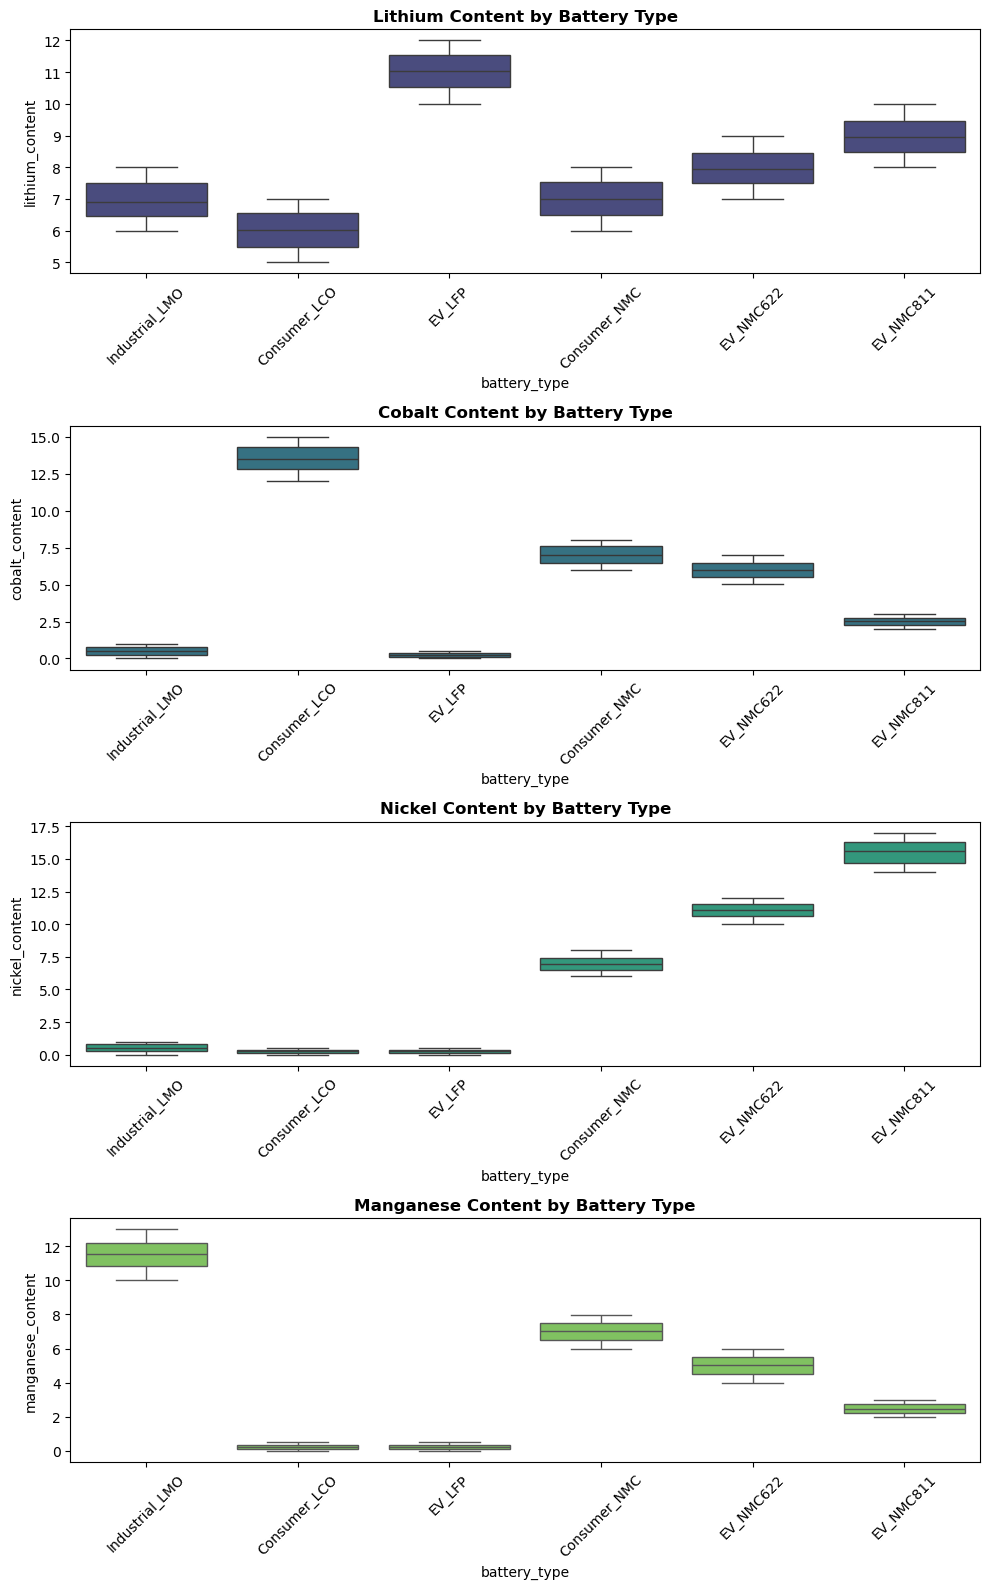

In [11]:
# Extract first 4 colors from Viridis (as RGB tuples)
viridis_colors = sns.color_palette("viridis", 4)

# Assign to metals (Li, Co, Ni, Mn)
metal_colors = {
    'lithium': viridis_colors[0],  
    'cobalt': viridis_colors[1],   
    'nickel': viridis_colors[2],   
    'manganese': viridis_colors[3] 
}

plt.figure(figsize=(10, 16))

# Lithium Content (Top)
plt.subplot(4, 1, 1)
sns.boxplot(
    data=df, 
    x='battery_type', 
    y='lithium_content',
    color=metal_colors['lithium']
)
plt.title('Lithium Content by Battery Type', fontweight='bold')
plt.xticks(rotation=45)

# Cobalt Content
plt.subplot(4, 1, 2)
sns.boxplot(
    data=df, 
    x='battery_type', 
    y='cobalt_content',
    color=metal_colors['cobalt']
)
plt.title('Cobalt Content by Battery Type', fontweight='bold')
plt.xticks(rotation=45)

# Nickel Content
plt.subplot(4, 1, 3)
sns.boxplot(
    data=df, 
    x='battery_type', 
    y='nickel_content',
    color=metal_colors['nickel']
)
plt.title('Nickel Content by Battery Type', fontweight='bold')
plt.xticks(rotation=45)

# Manganese Content (Bottom)
plt.subplot(4, 1, 4)
sns.boxplot(
    data=df, 
    x='battery_type', 
    y='manganese_content',
    color=metal_colors['manganese']
)
plt.title('Manganese Content by Battery Type', fontweight='bold')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## **Scatterplots and Density Curves for Metals by Battery Type**

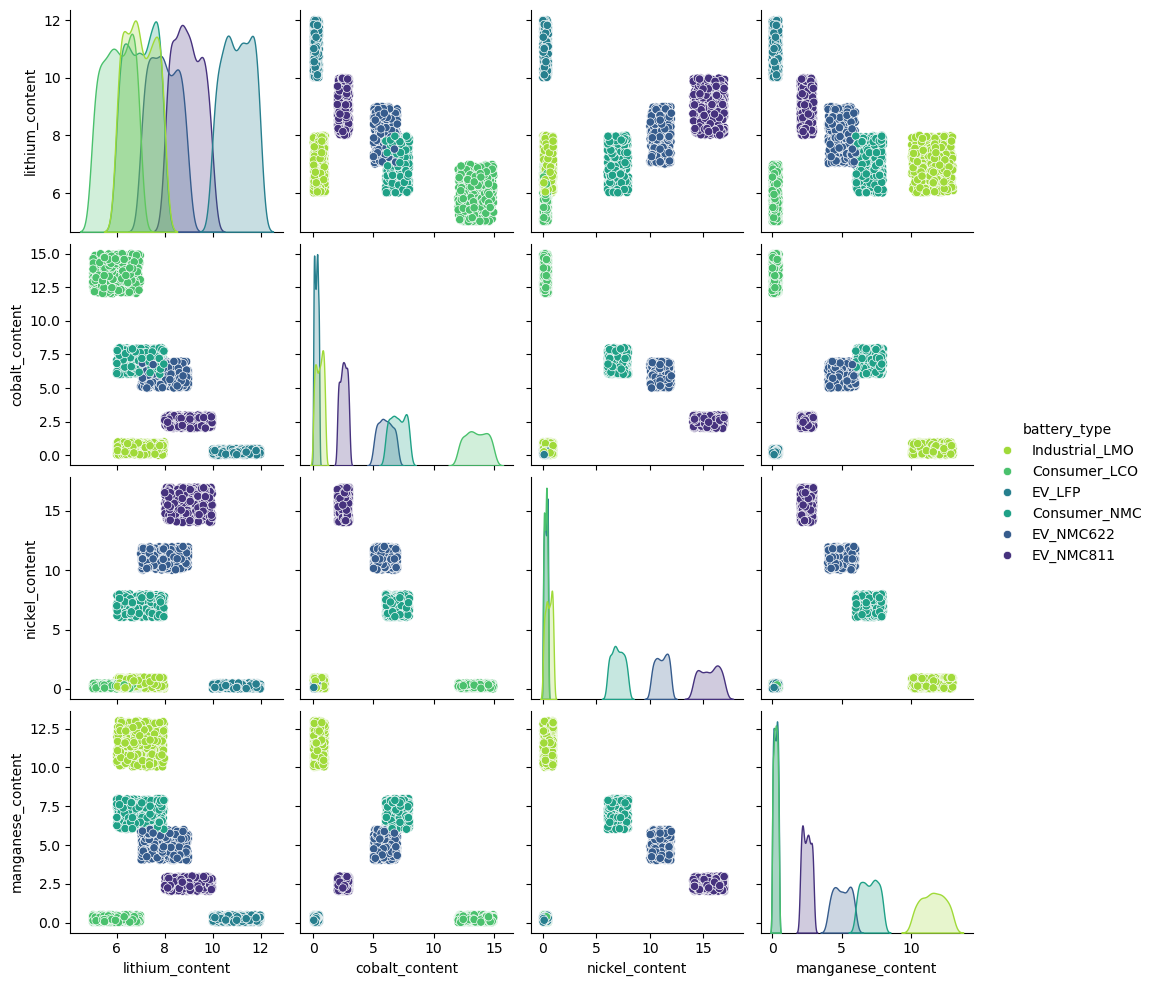

In [15]:
# Define custom Viridis colors for each battery_type
viridis_palette = sns.color_palette("viridis", len(df['battery_type'].unique()))
battery_colors = {
    'EV_NMC811': viridis_palette[0],
    'EV_NMC622': viridis_palette[1],
    'EV_LFP': viridis_palette[2],
    'Consumer_NMC': viridis_palette[3],
    'Consumer_LCO': viridis_palette[4],
    'Industrial_LMO': viridis_palette[5]
}

sns.pairplot(
    df[['lithium_content', 'cobalt_content', 'nickel_content', 'manganese_content', 'battery_type']], 
    hue='battery_type',
    palette=battery_colors,  # Use custom mapping
    diag_kind='kde'
)
plt.show()

## **Selected Metal to Metal Scatterplots**

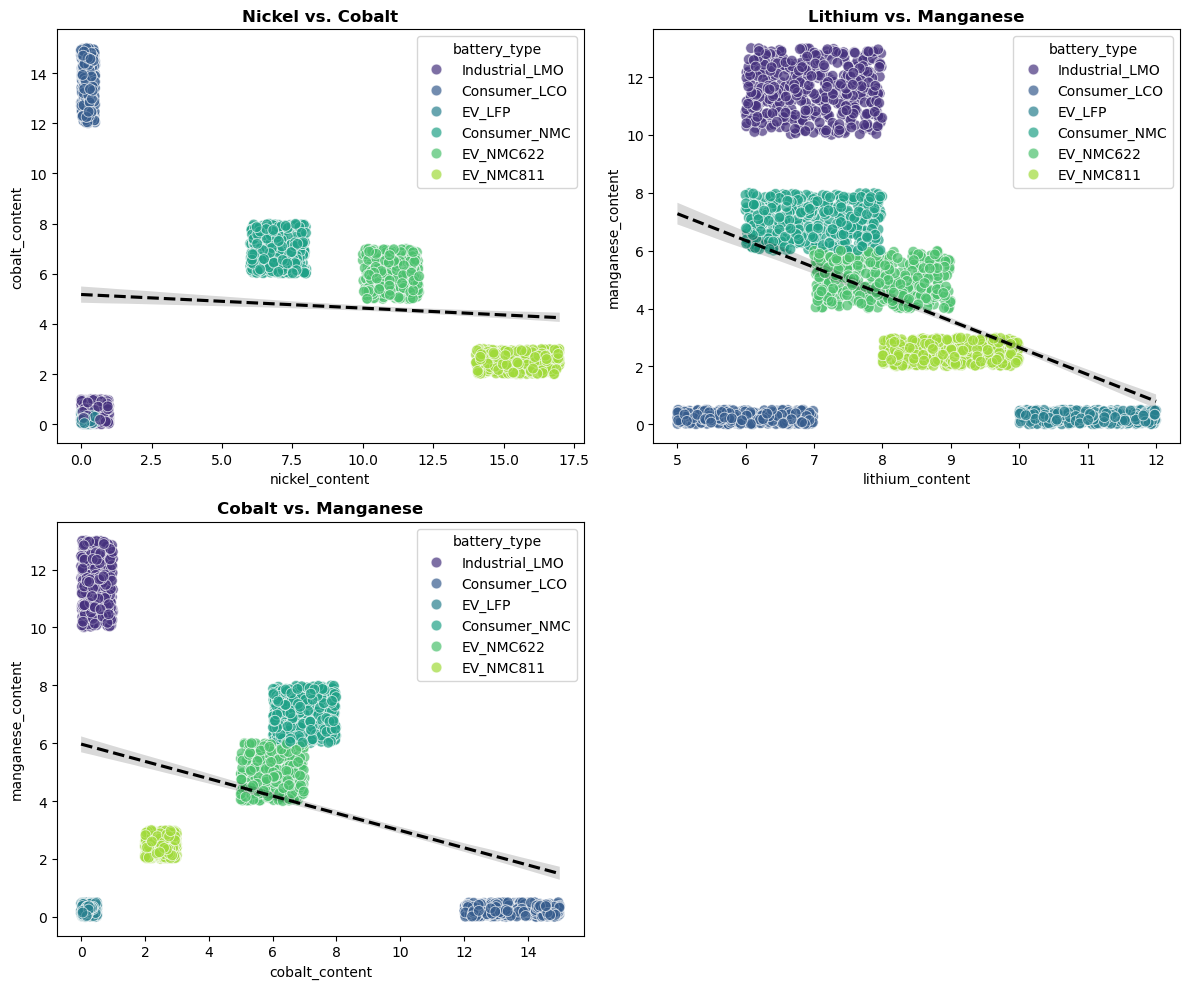

In [19]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])

# --- 1. Ni vs. Co (Top Left) ---
ax1 = plt.subplot(gs[0])
sns.scatterplot(
    data=df, 
    x='nickel_content', 
    y='cobalt_content',
    hue='battery_type',
    palette='viridis',
    alpha=0.7,
    s=60,
    ax=ax1
)
sns.regplot(
    data=df,
    x='nickel_content',
    y='cobalt_content',
    scatter=False,
    color='black',
    line_kws={'linestyle': '--'},
    ax=ax1
)
plt.title('Nickel vs. Cobalt', fontweight='bold')

# --- 2. Li vs. Mn (Top Right) ---
ax2 = plt.subplot(gs[1])
sns.scatterplot(
    data=df, 
    x='lithium_content', 
    y='manganese_content',
    hue='battery_type',
    palette='viridis',
    alpha=0.7,
    s=60,
    ax=ax2
)
sns.regplot(
    data=df,
    x='lithium_content',
    y='manganese_content',
    scatter=False,
    color='black',
    line_kws={'linestyle': '--'},
    ax=ax2
)
plt.title('Lithium vs. Manganese', fontweight='bold')

# --- 3. Co vs. Mn (Bottom Left) ---
ax3 = plt.subplot(gs[2])
sns.scatterplot(
    data=df, 
    x='cobalt_content', 
    y='manganese_content',
    hue='battery_type',
    palette='viridis',
    alpha=0.7,
    s=60,
    ax=ax3
)
sns.regplot(
    data=df,
    x='cobalt_content',
    y='manganese_content',
    scatter=False,
    color='black',
    line_kws={'linestyle': '--'},
    ax=ax3
)
plt.title('Cobalt vs. Manganese', fontweight='bold')

# --- 4. Legend (Bottom Right) ---
ax4 = plt.subplot(gs[3])
ax4.axis('off')  # Hide axes

# Get legend handles/labels from any plot
handles, labels = ax1.get_legend_handles_labels()

# Add regression line to legend
reg_line = plt.Line2D([], [], color='black', linestyle='--', label='Overall Trend')
handles.append(reg_line)

plt.tight_layout()
plt.show()

## **Kernel Density Plots for Metal Recovery Rates**

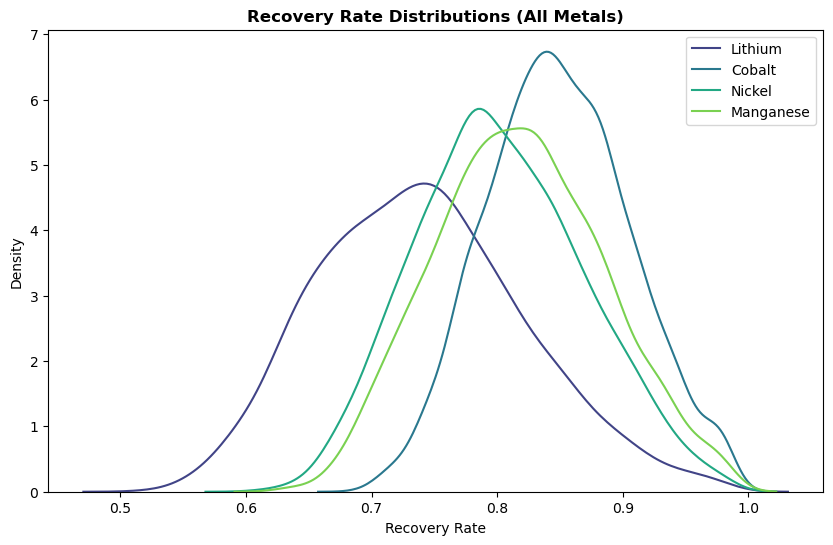

In [13]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='lithium_recovery_rate', color=metal_colors['lithium'], label='Lithium')
sns.kdeplot(data=df, x='cobalt_recovery_rate', color=metal_colors['cobalt'], label='Cobalt')
sns.kdeplot(data=df, x='nickel_recovery_rate', color=metal_colors['nickel'], label='Nickel')
sns.kdeplot(data=df, x='manganese_recovery_rate', color=metal_colors['manganese'], label='Manganese')
plt.title('Recovery Rate Distributions (All Metals)', fontweight='bold')
plt.xlabel('Recovery Rate')
plt.legend()
plt.show()

# **K-Means Cluster Analysis**

## First, Determine the number if clusters (K) 

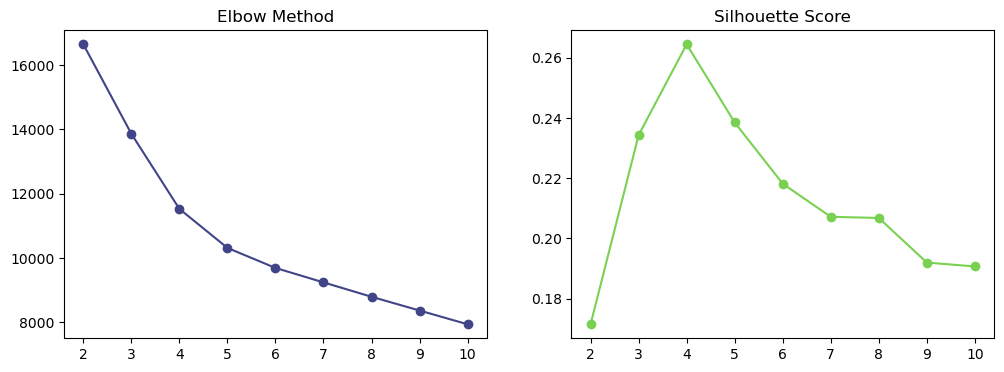

In [22]:
features = ['lithium_content', 'cobalt_content', 'nickel_content', 'manganese_content',
            'age_years', 'charge_cycles', 'recycling_temp', 'recycling_time']

# Scale data
X = df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow + Silhouette analysis
k_values = range(2, 11)  
wcss = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot both metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(k_values, wcss, marker='o', color=metal_colors['lithium'])
ax1.set_title('Elbow Method')
ax2.plot(k_values, silhouette_scores, marker='o',  color=metal_colors['manganese'])
ax2.set_title('Silhouette Score')
plt.show()


Using the Elbow method and the Silhouette score, we can see that K = 4.  
<br>
To be sure, I will run the K-means Cluster Analysis, setting K to 3, 4, and 5 to see how they compare.

'For k = 3:'

'Inertia (WCSS): 13866.4208'

'Silhouette Score: 0.2343'

'Cluster Centers (Original Units):'

   lithium_content  cobalt_content  nickel_content  manganese_content  \
0            11.02            0.24            0.26               0.25   
1             6.01           13.52            0.25               0.24   
2             7.70            3.91            8.27               6.66   

   age_years  charge_cycles  recycling_temp  recycling_time  
0       5.19         948.97           65.39            5.05  
1       5.29         943.69           65.36            4.99  
2       5.26         947.02           65.18            4.96  


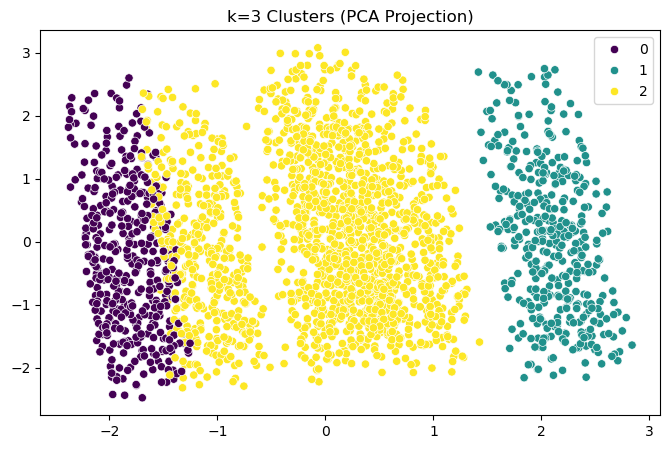

'For k = 4:'

'Inertia (WCSS): 11528.3481'

'Silhouette Score: 0.2645'

'Cluster Centers (Original Units):'

   lithium_content  cobalt_content  nickel_content  manganese_content  \
0             6.01           13.52            0.25               0.24   
1            11.02            0.24            0.26               0.25   
2             7.97            5.17           11.14               4.86   
3             6.98            0.51            0.53              11.54   

   age_years  charge_cycles  recycling_temp  recycling_time  
0       5.29         943.69           65.36            4.99  
1       5.19         948.97           65.39            5.05  
2       5.30         936.49           65.22            4.93  
3       5.15         975.49           65.08            5.07  


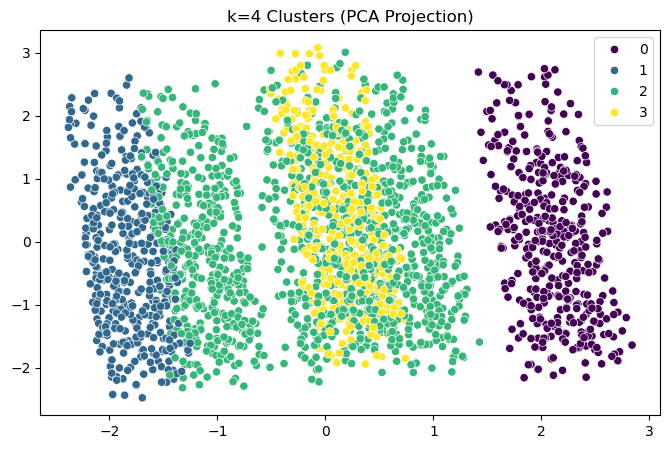

'For k = 5:'

'Inertia (WCSS): 10313.5537'

'Silhouette Score: 0.2385'

'Cluster Centers (Original Units):'

   lithium_content  cobalt_content  nickel_content  manganese_content  \
0            11.02            0.24            0.26               0.25   
1             6.01           13.52            0.25               0.24   
2             7.94            5.24           11.00               4.92   
3             8.00            5.09           11.28               4.79   
4             6.98            0.51            0.53              11.54   

   age_years  charge_cycles  recycling_temp  recycling_time  
0       5.19         948.97           65.39            5.05  
1       5.29         943.69           65.36            4.99  
2       7.41         589.01           63.77            5.02  
3       2.97        1318.83           66.82            4.83  
4       5.15         975.49           65.08            5.07  


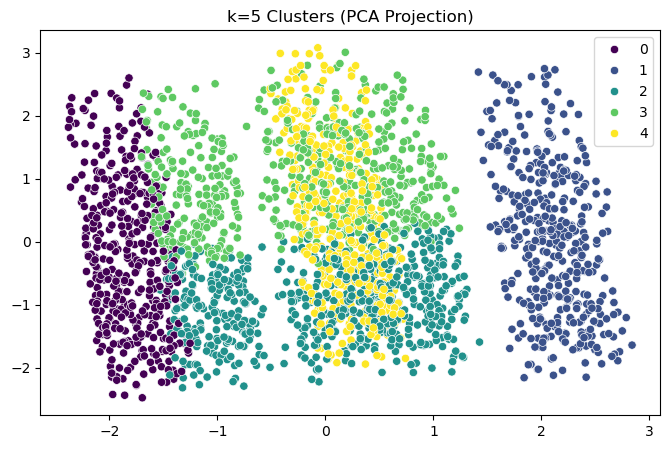

In [26]:
cluster_values = [3,4,5]
kmeans_models = {}

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

for k in cluster_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)  
    df[f'cluster_k{k}'] = labels 
    kmeans_models[k] = kmeans

    #Metrics
    inertia = kmeans.inertia_
    silhouette_avg = silhouette_score(X_scaled, labels)

    # Print Metrics
    display(f"For k = {k}:")
    display(f"Inertia (WCSS): {kmeans.inertia_:.4f}")
    display(f"Silhouette Score: {silhouette_avg:.4f}")  

    # Inverse-transform centers
    centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
    df_centers = pd.DataFrame(centers_original, columns=features)
    display("Cluster Centers (Original Units):")
    print(df_centers.round(2))

    # Visualize
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="viridis")
    plt.title(f'k={k} Clusters (PCA Projection)')
    plt.show()

Inertia drops from 13,866 when K=3 to 11,528 when k=4. That is almost 17%. The drop from 4 to 5 is only 11%.
Additionally, the silhouette score peaks at 0.265 when k=4, representing optimal separation between clusters.
Finally, the four clusters align with standard battery types.
<br>
<br>
Next, we move to analyze the 4 clusters more closely.


Cluster Profiles (k=4)


lithium_content       cobalt_content       nickel_content        \
                      mean   std           mean   std           mean   std   
cluster_k4                                                                   
0                     6.01  0.59          13.52  0.86           0.25  0.14   
1                    11.02  0.58           0.24  0.15           0.26  0.15   
2                     7.97  1.00           5.17  2.02          11.14  3.64   
3                     6.98  0.60           0.51  0.29           0.53  0.29   

           manganese_content       age_years       charge_cycles          \
                        mean   std      mean   std          mean     std   
cluster_k4                                                                 
0                       0.24  0.14      5.29  2.76        943.69  629.96   
1                       0.25  0.14      5.19  2.77        948.97  621.85   
2                       4.86  1.95      5.30  2.77        936.49  608.55   
3                      11.54  0.83      5.15  2.76        975.49  650.66   

           recycling_temp        recycling_time        size  
                     mean    std           mean   std        
cluster_k4                                                   
0                   65.36  13.78           4.99  1.71   412  
1                   65.39  14.15           5.05  1.75   425  
2                   65.22  14.69           4.93  1.74  1214  
3                   65.08  14.45           5.07  1.75   449


Battery Type Distribution


cluster_k4,0,1,2,3
battery_type,,,,
Consumer_LCO,412,0,0,0
Consumer_NMC,0,0,431,0
EV_LFP,0,425,0,0
EV_NMC622,0,0,370,0
EV_NMC811,0,0,413,0
Industrial_LMO,0,0,0,449


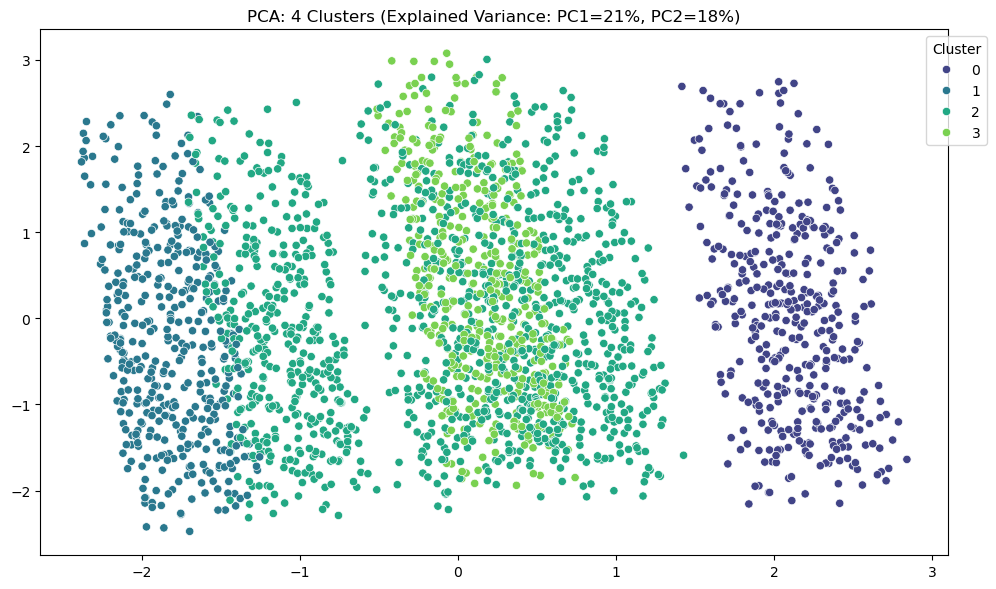

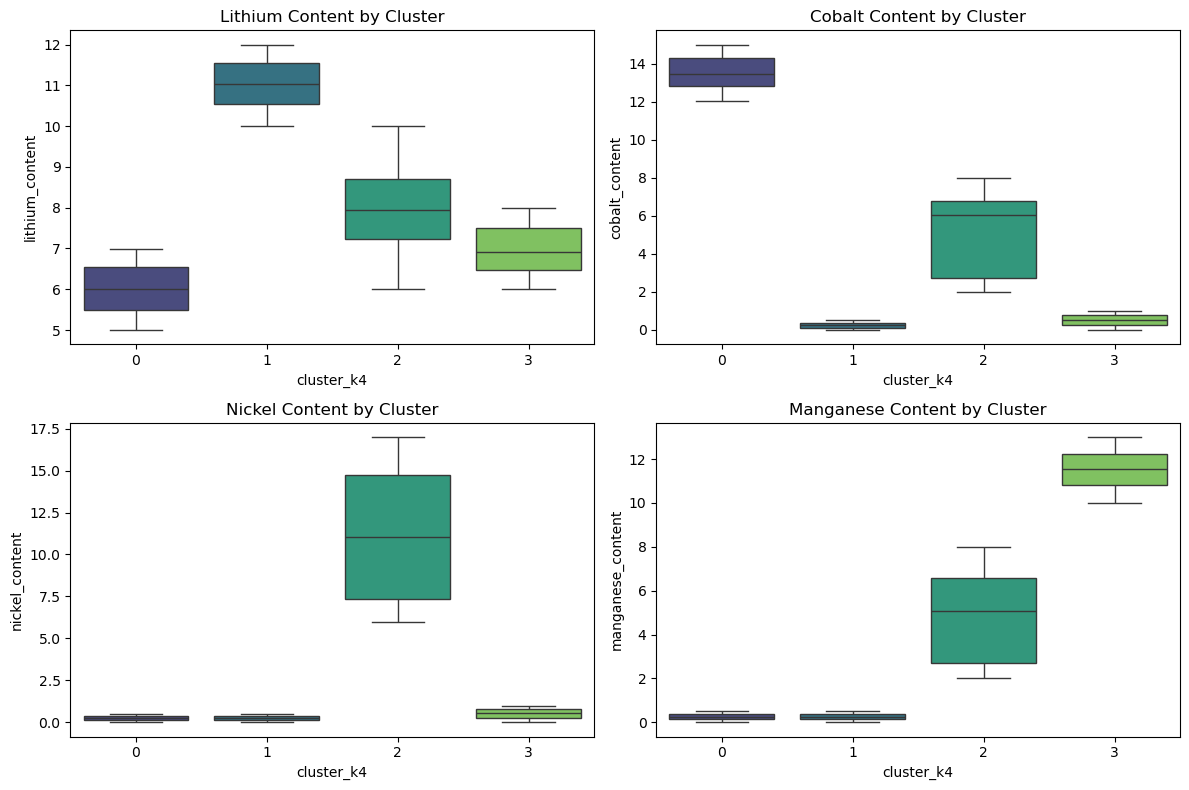

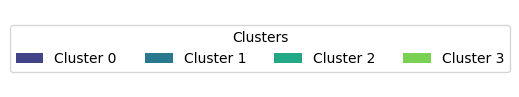

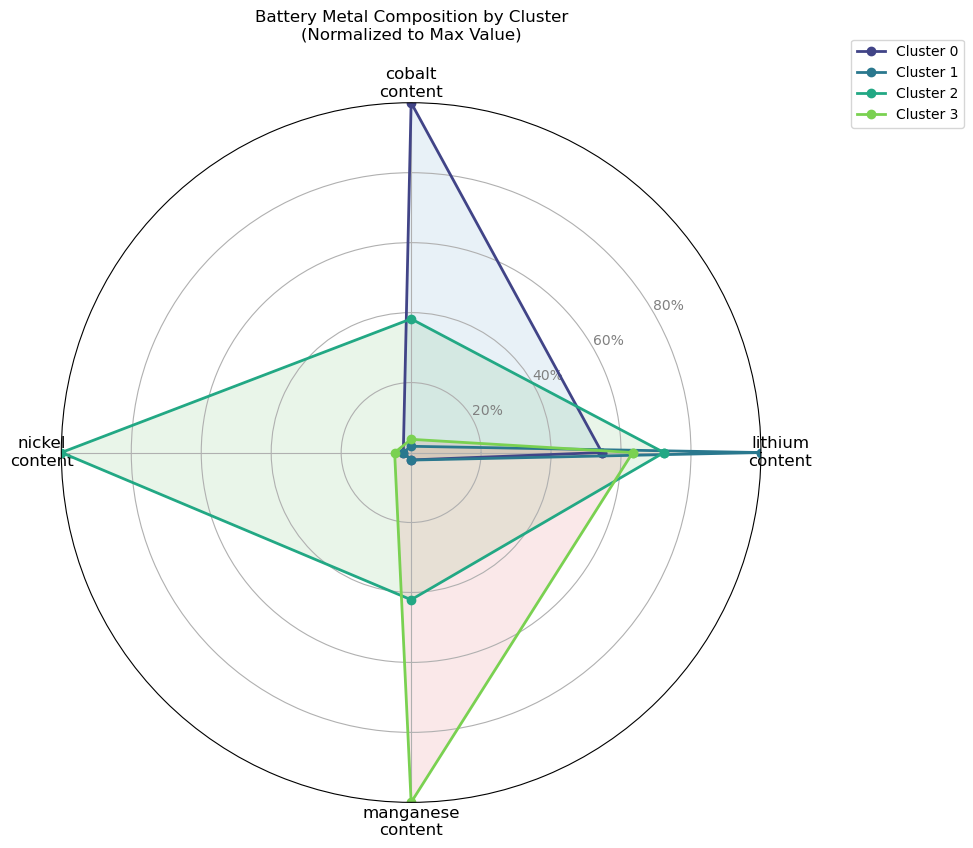

In [34]:
k = 4  # Optimal cluster count from prior analysis

# --- Cluster Assignment ---
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
df['cluster_k4'] = kmeans.labels_

# --- Cluster Statistics ---
print(f"\n{'='*50}\nCluster Profiles (k={k})\n{'='*50}")
profile = (df.groupby('cluster_k4')[features]
           .agg(['mean', 'std'])
           .round(2)
           .assign(size=df['cluster_k4'].value_counts().sort_index()))
display(profile)

# --- Battery Type Alignment ---
if 'battery_type' in df.columns:
    print(f"\n{'='*50}\nBattery Type Distribution\n{'='*50}")
    display(pd.crosstab(df['battery_type'], df['cluster_k4']))

# --- Visualizations ---
palette = sns.color_palette("viridis", n_colors=k)

# 1. PCA Plot (Colored by Cluster)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1],
    hue=df['cluster_k4'],
    palette=palette,
    legend='full'
)
plt.title(f'PCA: 4 Clusters (Explained Variance: PC1={pca.explained_variance_ratio_[0]:.0%}, PC2={pca.explained_variance_ratio_[1]:.0%})')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# 2. Composition Boxplots (Key Metals) - FIXED WARNINGS
metals = ['lithium_content', 'cobalt_content', 'nickel_content', 'manganese_content']
plt.figure(figsize=(12, 8))
for i, metal in enumerate(metals, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(
        data=df,
        x='cluster_k4',
        y=metal,
        hue='cluster_k4',  # Explicitly assign hue
        palette=palette,
        order=sorted(df['cluster_k4'].unique()),
        legend=False  # Disable individual legends
    )
    plt.title(f'{metal.replace("_", " ").title()} by Cluster')
plt.tight_layout()
plt.show()

# 3. Single Legend for All Boxplots
plt.figure(figsize=(6, 1))
plt.axis('off')
legend_elements = [Patch(facecolor=palette[i], 
                   label=f'Cluster {i}') for i in range(k)]
plt.legend(handles=legend_elements, 
           title='Clusters',
           ncol=k,
           loc='center')
plt.show()

# 4. Cluster Radar Chart (Optional)
from matplotlib.patches import Patch

# 1. Prepare the data (use your actual metal columns)
metals = ['lithium_content', 'cobalt_content', 'nickel_content', 'manganese_content']
cluster_means = df.groupby('cluster_k4')[metals].mean()

# 2. Normalize the data (0-1 scale for radar chart)
normalized_means = cluster_means / cluster_means.max().values

# 3. Create radar chart
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# Calculate angles for each axis
angles = np.linspace(0, 2*np.pi, len(metals), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Plot each cluster
for idx, row in normalized_means.iterrows():
    values = row.values.tolist()
    values += values[:1]  # Close the line
    ax.plot(angles, values, 'o-', linewidth=2, 
            label=f'Cluster {idx}', 
            color=sns.color_palette("viridis", 4)[idx])
    ax.fill(angles, values, alpha=0.1)

# Fix axis labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels([m.replace('_', '\n') for m in metals], fontsize=12)
ax.set_rlabel_position(30)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["20%", "40%", "60%", "80%"], color="grey", size=10)
plt.ylim(0, 1)

# Add legend and title
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Battery Metal Composition by Cluster\n(Normalized to Max Value)', pad=20)
plt.tight_layout()
plt.show()

## **K-Means Clustering Conclusion**  
**Four dominant battery types** identified, matching known chemistries (LFP, NMC, LCO, LMO).  
**Statistically validated** via silhouette score (0.265) and elbow method.  
**Caution**: Low PCA variance suggests considering alternative dimensionality reduction (e.g., UMAP).  
**Next Steps**: Test clustering robustness using alternative algorithm.

# DBSCAN Cluster Analysis

While k-means assumes spherical clusters, DBSCAN (Density-Based Spatial Clustering of Applications with Noise) 
identifies irregularly shaped groups based on data density, automatically detecting outliers as noise. 
This makes it ideal for our battery data where clusters may have complex geometries and overlapping compositions.
The results from the K-means analysis suggest Cluster 3 may contain density variations that DBSCAN can better resolve.

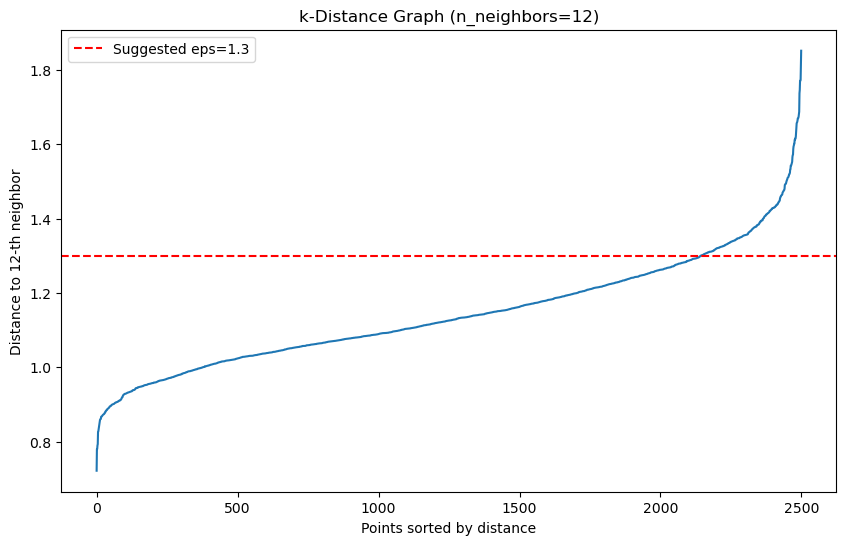


DBSCAN RESULTS (eps=1.3, min_samples=12):
• Clusters identified: 4
• Noise points: 7 (0.3%)
• Cluster distribution:
  - Cluster 0: 448 batteries (avg size: 112)
  - Cluster 1: 409 batteries (avg size: 102)
  - Cluster 2: 423 batteries (avg size: 106)
  - Cluster 3: 1213 batteries (avg size: 303)
• Silhouette: 0.265 (0=overlap, 1=separated)


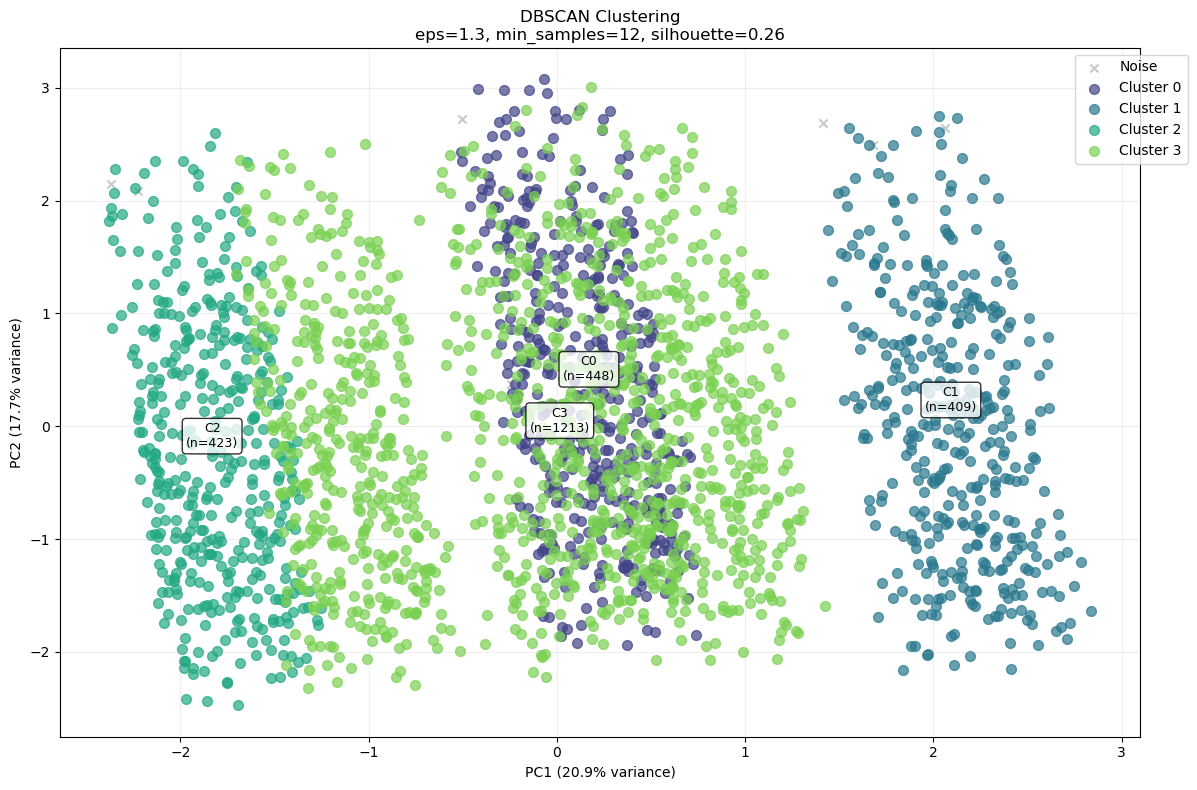

In [40]:
from sklearn.neighbors import NearestNeighbors

# STEP 1: Automated Epsilon Selection

n_neighbors = min(20, int(0.005 * len(X_scaled)))  # Dynamic neighbor selection

# Generate k-distance graph
nn = NearestNeighbors(n_neighbors=n_neighbors).fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)

plt.figure(figsize=(10, 6))
plt.plot(np.sort(distances[:, -1]))
plt.axhline(y=1.3, color='r', linestyle='--', label='Suggested eps=1.3')
plt.title(f'k-Distance Graph (n_neighbors={n_neighbors})')
plt.ylabel(f'Distance to {n_neighbors}-th neighbor')
plt.xlabel('Points sorted by distance')
plt.legend()
plt.show()

# STEP 2: DBSCAN Clustering
eps = 1.3              # From elbow point analysis
min_samples = 12        # ~0.5% of dataset (n=2500)
db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
df['dbscan_cluster'] = db.labels_

# STEP 3: Cluster Metrics
cluster_labels, counts = np.unique(db.labels_, return_counts=True)
n_clusters = len(cluster_labels) - 1  # Exclude noise
noise_pct = 100 * counts[cluster_labels == -1][0] / len(df)

print(f"""
DBSCAN RESULTS (eps={eps}, min_samples={min_samples}):
• Clusters identified: {n_clusters}
• Noise points: {counts[cluster_labels == -1][0]} ({noise_pct:.1f}%)
• Cluster distribution:""")

for label, count in zip(cluster_labels, counts):
    if label != -1:
        print(f"  - Cluster {label}: {count} batteries (avg size: {count/n_clusters:.0f})")

# Silhouette score (exclude noise)
if n_clusters > 1:
    mask = db.labels_ != -1
    sil_score = silhouette_score(X_scaled[mask], db.labels_[mask])
    print(f"• Silhouette: {sil_score:.3f} (0=overlap, 1=separated)")
    
# STEP 4: Enhanced Visualization
plt.figure(figsize=(12, 8))

# Create optimized color mapping
palette = sns.color_palette("viridis", max(n_clusters, 1))  # Ensure at least one color

# Explicitly include noise (-1) in the color mapping
color_map = {-1: (0.7, 0.7, 0.7)}  # Gray for noise

# Assign colors to clusters only
color_map.update({
    label: palette[i]
    for i, label in enumerate(label for label in cluster_labels if label != -1)
})

# Plot each cluster with proper color array
for label in cluster_labels:
    mask = (df['dbscan_cluster'] == label)
    plt.scatter(
        x=X_pca[mask, 0],
        y=X_pca[mask, 1],
        c=np.array([color_map[label]]),  # Correct color array format
        marker='x' if label == -1 else 'o',
        s=35 if label == -1 else 50,
        alpha=0.7,
        label='Noise' if label == -1 else f'Cluster {label}'
    )

# Add cluster annotations
for label in cluster_labels:
    if label != -1:
        plt.annotate(
            f'C{label}\n(n={counts[cluster_labels == label][0]})',
            xy=(np.median(X_pca[db.labels_ == label, 0]),
                np.median(X_pca[db.labels_ == label, 1])),
            xytext=(0, 10),
            textcoords='offset points',
            ha='center',
            bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8),
            fontsize=9
        )

plt.title(
    f'DBSCAN Clustering\n'
    f'eps={eps}, min_samples={min_samples}, '
    f'silhouette={sil_score:.2f}' if n_clusters >1 else ''
)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

In [43]:
# =============================================
# CLUSTER QUALITY METRICS
# =============================================

# 1. Basic Cluster Stats
n_clusters = len(np.unique(db.labels_[db.labels_ != -1]))  # Exclude noise
noise_pct = 100 * np.sum(db.labels_ == -1) / len(db.labels_)
cluster_counts = np.unique(db.labels_, return_counts=True)

print(f"""
{' DBSCAN CLUSTER EVALUATION ':=^80}
• Clusters found: {n_clusters}
• Noise points: {np.sum(db.labels_ == -1)} ({noise_pct:.1f}% of data)
• Avg cluster size: {np.mean(cluster_counts[1][cluster_counts[0] != -1]):.0f} batteries
• Largest cluster: {np.max(cluster_counts[1][cluster_counts[0] != -1])} batteries
• Smallest cluster: {np.min(cluster_counts[1][cluster_counts[0] != -1])} batteries
""")

# 2. Silhouette Analysis (exclude noise)
if n_clusters > 1:
    from sklearn.metrics import silhouette_score
    mask = db.labels_ != -1  # Exclude noise for scoring
    sil_score = silhouette_score(X_scaled[mask], db.labels_[mask])
    print(f"• Silhouette Score: {sil_score:.3f} (0=overlap, 1=well-separated)")
    if sil_score < 0.25:
        print("  Warning: Low score suggests weak cluster structure")
    elif sil_score < 0.5:
        print("  Fair: Some cluster separation but overlapping")
    else:
        print("  Good: Clear cluster separation")
else:
    print("• Silhouette Score: N/A (only 1 cluster)")

# 3. Cluster Composition Analysis
if 'battery_type' in df.columns:
    print(f"\n{' CLUSTER COMPOSITION BY BATTERY TYPE ':-^80}")
    
    # Crosstab with raw counts
    composition_table = pd.crosstab(df['battery_type'], df['dbscan_cluster'])
    
    # Rename columns header to match requested format
    composition_table.columns.name = f"cluster_k{n_clusters}"
    
    # Display table
    display(composition_table)

# 4. Dimensionality Check
print(f"\n{' DIMENSIONALITY WARNING ':-^80}")
print(f"PCA explains {100*pca.explained_variance_ratio_[:2].sum():.1f}% variance in 2D")
if pca.explained_variance_ratio_[:2].sum() < 0.5:
    print("Warning: Low explained variance - consider:")
    print("- Using original features (not PCA-reduced) for DBSCAN")
    print("- Trying UMAP/t-SNE for visualization")


========================== DBSCAN CLUSTER EVALUATION ===========================
• Clusters found: 4
• Noise points: 7 (0.3% of data)
• Avg cluster size: 623 batteries
• Largest cluster: 1213 batteries
• Smallest cluster: 409 batteries

• Silhouette Score: 0.265 (0=overlap, 1=well-separated)
  Fair: Some cluster separation but overlapping

--------------------- CLUSTER COMPOSITION BY BATTERY TYPE ----------------------


cluster_k4,-1,0,1,2,3
battery_type,,,,,
Consumer_LCO,3,0,409,0,0
Consumer_NMC,0,0,0,0,431
EV_LFP,2,0,0,423,0
EV_NMC622,1,0,0,0,369
EV_NMC811,0,0,0,0,413
Industrial_LMO,1,448,0,0,0



---------------------------- DIMENSIONALITY WARNING ----------------------------
PCA explains 38.5% variance in 2D
- Using original features (not PCA-reduced) for DBSCAN
- Trying UMAP/t-SNE for visualization


## DBSCAN Clustering Conclusion

Successfully identified **four core battery clusters** with a small proportion of noise points (0.3% of data).  
Effectively captured density-based structures, particularly distinguishing **Industrial_LMO as a high-density core within a broader NMC cluster.**  
Demonstrated **superior outlier detection** compared to K-Means, identifying potential atypical battery compositions.  
**Silhouette score** (0.265) suggests moderate separation but some overlap, possibly due to intermediate chemistries.  



# Overall Conclusions

This exploratory analysis demonstrates how clustering techniques can differentiate battery types based on their metal compositions.  
<br>
K-Means effectively identified broad compositional groups, while DBSCAN was better at detecting density-based structures and outliers.  
<br>
The results highlight distinct clustering patterns, such as the separation of EV batteries and the strong grouping of NMC chemistries.    
<br>
While these insights are based on synthetic data, they illustrate the potential of clustering methods in battery recycling applications. 
